## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Importing Traffic Data(Target)

In [2]:
JioTraffic=pd.read_excel('DataSet_DataAnalyst_Jio_Projections_Case Study.xlsx',sheet_name=1,parse_dates=True,)

In [3]:
JioTraffic.head()

,Date,Traffic
0,2018-01-01,20050
1,2018-01-02,32631
2,2018-01-03,61233
3,2018-01-04,68305
4,2018-01-05,54619


## Importing Content Type data (Independent Variables)

In [4]:
JioContent=pd.read_excel('DataSet_DataAnalyst_Jio_Projections_Case Study.xlsx',sheet_name=2,parse_dates=True)

In [5]:
JioContent.head()

,Date no,Tier 1 - Video,Tier 2 - Video,Tier 3 - Video,Tier 4 - Video,Tier 5 - Video,Tier 6 - Video,Tier 7 - Video,Tier 8 - Video,Tier 9 - Video,Tier 1 - Non Video,Tier 2 - Non Video,Tier 3 - Non Video,Tier 4 - Non Video,Tier 5 - Non Video,Tier 6 - Non Video,Tier 7 - Non Video,Tier 8 - Non Video,Tier 9 - Non Video
0,2018-01-01,0,0,1,4,0,3,0,5,1,0,0,1,0,0,0,0,0,8
1,2018-01-02,0,0,3,4,0,1,0,4,3,0,0,1,0,0,0,0,0,0
2,2018-01-03,0,0,3,3,0,1,0,7,3,0,0,0,4,0,0,0,0,0
3,2018-01-04,0,1,1,9,0,1,0,7,3,0,0,0,0,0,0,0,8,8
4,2018-01-05,0,0,1,7,0,1,0,3,3,0,0,0,0,0,0,0,0,8


#### Making Data the Index

In [6]:
JioTraffic.set_index('Date',inplace=True)
JioContent.set_index('Date no',inplace=True)

### Visualizing the Data

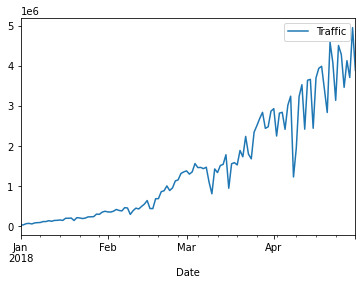

In [7]:
JioTraffic.plot()

# we can clearly see that is an upward trend in the Traffic Data 

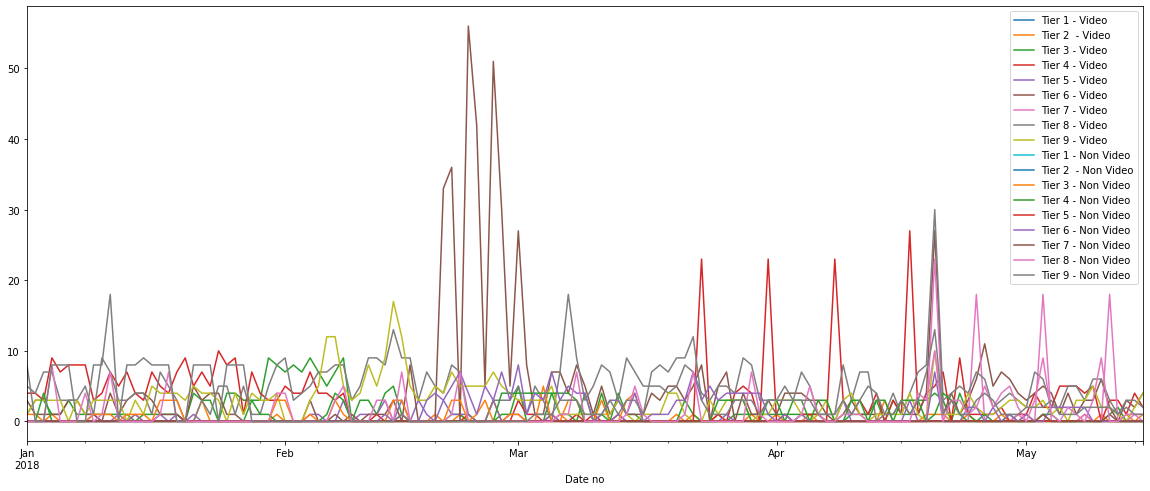

In [8]:
JioContent.plot(figsize=(20,8))

# from the plots we can see that this is no trend in predictive variables as it continously centered around a specific
# values

#### Plotting independ variables separately

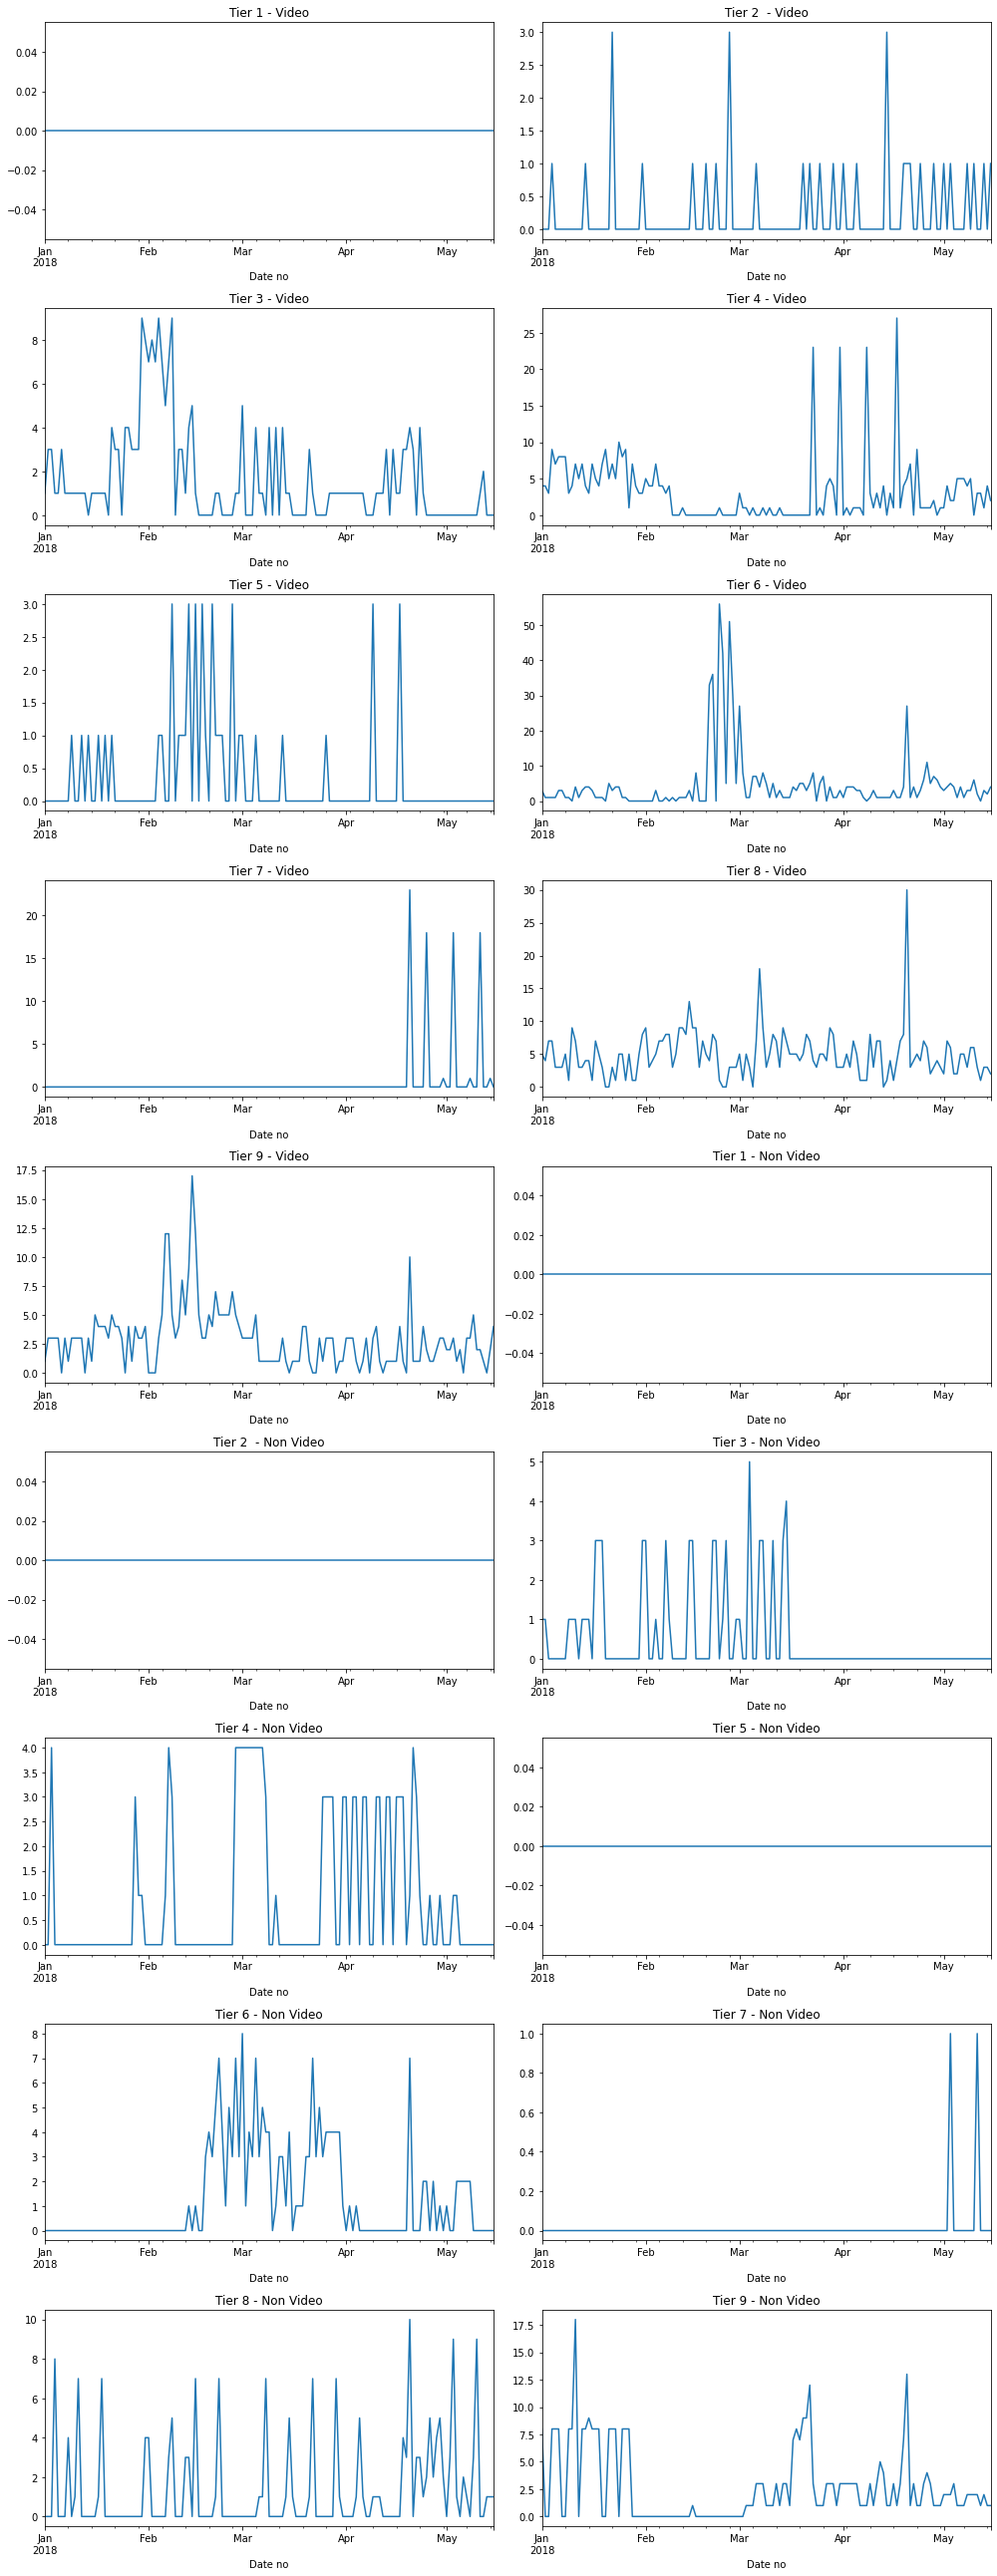

In [9]:
def Visualize(data):
    features=list(JioContent.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig,axes=plt.subplots(nrows=int(np.ceil(feature_size/2)),ncols=2,figsize=(14,feature_size*2))
    for i in range(feature_size):
        key=features[i]
        t_data=data[key]
        t_data.head()
        ax=t_data.plot(ax=axes[i//2,i%2],title="{}".format(key))
    plt.tight_layout()
    
Visualize(JioContent)

In [10]:
# From the graph above we can clearly see that for a few of the content type there is not a single content throughout
# the analysis period, so we will not include those varibales in our forecasting

# We will also drop Tier 7 Video and non Video as they will not be good predictors as they have zero content for more than 
# 90% days of the data under consideration

JioContentNew= JioContent.drop(['Tier 1 - Video','Tier 1 - Non Video','Tier 2  - Non Video','Tier 5 - Non Video','Tier 7 - Video','Tier 7 - Non Video'],axis=1)

In [11]:
JioContentNew.shape

(135, 12)

In [12]:
# for content data since we even have data for the prediction period, we will create new df of those columns
# and keep on data till april in the original df for analysis

JioContentTrain=JioContentNew.iloc[JioContentNew.index <="2018-04-30"]
JioContentPred=JioContentNew.iloc[JioContentNew.index >"2018-04-30"]

In [13]:
JioContentTrain

,Tier 2 - Video,Tier 3 - Video,Tier 4 - Video,Tier 5 - Video,Tier 6 - Video,Tier 8 - Video,Tier 9 - Video,Tier 3 - Non Video,Tier 4 - Non Video,Tier 6 - Non Video,Tier 8 - Non Video,Tier 9 - Non Video
Date no,,,,,,,,,,,,
2018-01-01,0,1,4,0,3,5,1,1,0,0,0,8
2018-01-02,0,3,4,0,1,4,3,1,0,0,0,0
2018-01-03,0,3,3,0,1,7,3,0,4,0,0,0
2018-01-04,1,1,9,0,1,7,3,0,0,0,8,8
2018-01-05,0,1,7,0,1,3,3,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-26,0,0,1,0,11,6,1,0,1,0,5,4
2018-04-27,0,0,1,0,5,2,1,0,0,2,2,3
2018-04-28,1,0,2,0,7,3,2,0,0,0,4,1


In [14]:
JioContentPred

,Tier 2 - Video,Tier 3 - Video,Tier 4 - Video,Tier 5 - Video,Tier 6 - Video,Tier 8 - Video,Tier 9 - Video,Tier 3 - Non Video,Tier 4 - Non Video,Tier 6 - Non Video,Tier 8 - Non Video,Tier 9 - Non Video
Date no,,,,,,,,,,,,
2018-05-01,1,0,1,0,3,2,2,0,0,1,0,2
2018-05-02,0,0,4,0,4,7,2,0,0,0,3,2
2018-05-03,1,0,2,0,5,6,3,0,1,0,9,2
2018-05-04,0,0,2,0,4,2,1,0,1,2,1,3
2018-05-05,0,0,5,0,1,2,2,0,0,2,0,1
2018-05-06,0,0,5,0,4,5,0,0,0,2,2,1
2018-05-07,0,0,5,0,1,5,3,0,0,2,1,1
2018-05-08,1,0,4,0,3,3,3,0,0,2,0,2
2018-05-09,0,0,5,0,3,6,5,0,0,0,3,2


### Testing to see if the Data is Stationary
Using Dickey Fuller Test

In [15]:
#Null Hypothesis(H0): Series is not stationary
#Alternate Hupothesis(H1): Series is stationary

for i in range(len(JioContentTrain.columns)):
    result=adfuller(JioContentTrain[JioContentTrain.columns[i]])
    
    if result[1]>0.05:
        print('{} -Series is not Stationary'.format(JioContentTrain.columns[i]))
    else:
        print('{} - Series is Stationary'.format(JioContentTrain.columns[i]))

Tier 2  - Video - Series is Stationary
Tier 3 - Video -Series is not Stationary
Tier 4 - Video -Series is not Stationary
Tier 5 - Video -Series is not Stationary
Tier 6 - Video - Series is Stationary
Tier 8 - Video - Series is Stationary
Tier 9 - Video -Series is not Stationary
Tier 3 - Non Video -Series is not Stationary
Tier 4 - Non Video - Series is Stationary
Tier 6 - Non Video -Series is not Stationary
Tier 8 - Non Video -Series is not Stationary
Tier 9 - Non Video -Series is not Stationary


#### Dickey Fuller on Target Variable

In [16]:
#Null Hypothesis(H0): Series is not stationary
#Alternate Hupothesis(H1): Series is stationary


result=adfuller(JioTraffic['Traffic'])
if result[1]>0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Series is not Stationary


### Differencing to make data stationary 

In [17]:
for i in range(len(JioContentTrain.columns)):
    result=adfuller(JioContentTrain[JioContentTrain.columns[i]].diff()[1:]) # first order differencing
    
    if result[1]>0.05:
        print('{} -Series is not Stationary'.format(JioContentTrain.columns[i]))
    else:
        print('{} - Series is Stationary'.format(JioContentTrain.columns[i]))

Tier 2  - Video - Series is Stationary
Tier 3 - Video - Series is Stationary
Tier 4 - Video - Series is Stationary
Tier 5 - Video - Series is Stationary
Tier 6 - Video - Series is Stationary
Tier 8 - Video - Series is Stationary
Tier 9 - Video - Series is Stationary
Tier 3 - Non Video - Series is Stationary
Tier 4 - Non Video - Series is Stationary
Tier 6 - Non Video - Series is Stationary
Tier 8 - Non Video - Series is Stationary
Tier 9 - Non Video - Series is Stationary


In [18]:
result=adfuller(JioTraffic['Traffic'].diff()[1:])
if result[1]>0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Series is Stationary


### Granger Causality Test
to determine which feature is useful in determining the Target

In [19]:

JoinedData= pd.concat([JioTraffic,JioContentTrain],axis=1,join='inner')

In [24]:
# Null Hypothesis(H0): Xt does not causes Yt
# Alternate Hypothesis(HA): Xt casuses Yt

max_lags=8

for i in range (len(JoinedData.columns)-1):
    results=grangercausalitytests(x=JoinedData[['Traffic',JoinedData.columns[i+1]]],maxlag=8,verbose=False)
    p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
    print('Column: {} , p_values - {}'.format(JoinedData.columns[i+1],p_values))

Column: Tier 2  - Video , p_values - [0.4389, 0.5589, 0.7732, 0.8015, 0.9061, 0.9261, 0.8495, 0.8321]
Column: Tier 3 - Video , p_values - [0.9196, 0.2736, 0.6095, 0.5605, 0.5387, 0.2239, 0.2442, 0.3285]
Column: Tier 4 - Video , p_values - [0.3197, 0.9284, 0.6178, 0.6524, 0.6896, 0.8066, 0.8101, 0.4864]
Column: Tier 5 - Video , p_values - [0.6188, 0.6094, 0.0896, 0.2126, 0.338, 0.3302, 0.4111, 0.4891]
Column: Tier 6 - Video , p_values - [0.3073, 0.64, 0.7625, 0.8634, 0.9106, 0.954, 0.9429, 0.8416]
Column: Tier 8 - Video , p_values - [0.0202, 0.1789, 0.2203, 0.2065, 0.394, 0.4408, 0.4313, 0.1523]
Column: Tier 9 - Video , p_values - [0.7707, 0.0518, 0.1416, 0.2065, 0.1607, 0.218, 0.4654, 0.5214]
Column: Tier 3 - Non Video , p_values - [0.0968, 0.1916, 0.3845, 0.5239, 0.6355, 0.7364, 0.8437, 0.9008]
Column: Tier 4 - Non Video , p_values - [0.0225, 0.0089, 0.0154, 0.0058, 0.0035, 0.0033, 0.0091, 0.0045]
Column: Tier 6 - Non Video , p_values - [0.5884, 0.8475, 0.4166, 0.5524, 0.5743, 0.5333,

In [ ]:
# from the above granger Causality test we can see that p-value of Tier 4 non video has p-values less that 0.05 across most
# of the lags hence it is the only one causally related to the Traffic 
# we can also include  tier 8 video, if we are considering only for lag 1

In [25]:
# We will use just 'Tier 4 - Non Video' along with 'Traffic'

df_input=JoinedData[['Traffic','Tier 4 - Non Video']]
df_input.shape

(120, 2)

In [26]:
### Train Test Split
df_train=df_input[:-12]
df_test=df_input[-12:]

In [27]:
df_train.shape

(108, 2)

In [28]:
# defining the VAR model with the differenced data to use  the select Order function to find the optimim minimum lag

model=VAR(df_train.diff()[1:])

In [29]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

# from below we can see that the 2nd lag is the optimum

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        26.09       26.14   2.135e+11       26.11
1        26.04       26.21   2.028e+11       26.10
2       25.64*      25.92*  1.363e+11*      25.75*
3        25.66       26.05   1.389e+11       25.82
4        25.73       26.24   1.497e+11       25.94
5        25.75       26.37   1.524e+11       26.00
6        25.80       26.54   1.617e+11       26.10
7        25.75       26.60   1.540e+11       26.10
8        25.77       26.74   1.577e+11       26.16
9        25.82       26.90   1.662e+11       26.26
10       25.88       27.07   1.776e+11       26.36
11       25.91       27.21   1.831e+11       26.43
12       25.97       27.39   1.972e+11       26.55
13       25.91       27.44   1.874e+11       26.53
14       25.88       27.53   1.837e+11       26.55
15       25.96       27.72   2.013e+11       26.67
16       25.91       27.78   1.

In [173]:
#converting the datatype to float statsmodels tools take float values

df_train['Traffic']=df_train['Traffic'].astype('float32')
df_train['Tier 4 - Non Video']=df_train['Tier 4 - Non Video'].astype('float32')


In [175]:

VAR_model=VARMAX(df_train,order=(2,0),enforce_stationarity=True)  
# since we are building a VAR model, order of MA(Moving Average) is specified as  0
fitted_model=VAR_model.fit()
print(fitted_model.summary())

                                   Statespace Model Results                                  
Dep. Variable:     ['Traffic', 'Tier 4 - Non Video']   No. Observations:                  108
Model:                                        VAR(2)   Log Likelihood               -1688.648
                                         + intercept   AIC                           3403.296
Date:                               Tue, 31 Aug 2021   BIC                           3438.164
Time:                                       02:18:50   HQIC                          3417.434
Sample:                                   01-01-2018                                         
                                        - 04-18-2018                                         
Covariance Type:                                 opg                                         
Ljung-Box (Q):               100.62, 23.36   Jarque-Bera (JB):       338.71, 104.84
Prob(Q):                        0.00, 0.98   Prob(JB):                

###  Test Forecasting


In [176]:
n_forecast=12
predict=fitted_model.get_prediction(start=len(df_train), end=len(df_train)+n_forecast-1)
predictions=predict.predicted_mean

In [177]:
predictions.columns=['Traffic_predicted','Tier4-NonVideo_predicted']
predictions

,Traffic_predicted,Tier4-NonVideo_predicted
2018-04-19,3.911919e+06,2.770108
2018-04-20,3.880048e+06,2.671165
2018-04-21,3.844634e+06,2.597980
2018-04-22,3.816708e+06,2.553021
2018-04-23,3.790372e+06,2.520495
2018-04-24,3.765889e+06,2.496365
2018-04-25,3.742309e+06,2.476780
2018-04-26,3.719415e+06,2.459975
2018-04-27,3.696980e+06,2.444794
2018-04-28,3.674902e+06,2.430610


### Evaluating the Test Results


In [178]:
 test_vs_pred=pd.concat([df_test,predictions],axis=1)

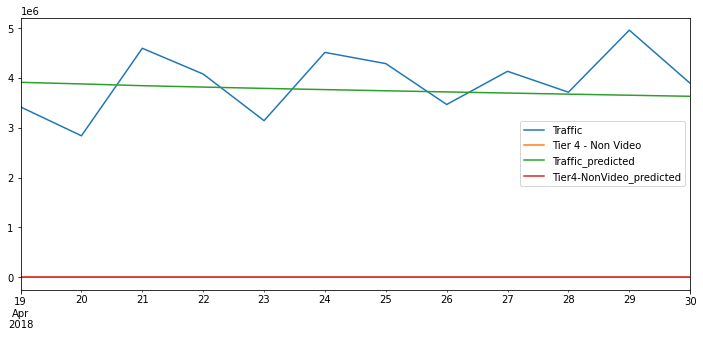

In [180]:
test_vs_pred.plot(figsize=(12,5))

#### Evaluation Error Matrix of Target 

In [182]:
from sklearn.metrics import mean_squared_error as mse
import math
from statistics import mean

RMSE=math.sqrt(mse(predictions['Traffic_predicted'],df_test['Traffic']))
print('Mean Value of Traffic is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Traffic']),RMSE))

Mean Value of Traffic is : 3919919.6666666665. Root Mean Squared Error is :662185.3304560356


In [ ]:
# Hence the Model is performing considerablly well as seen from the plot above, as well as the RMSE Values as it is
# way lower than the mean value

## Final Forecasting on Future Dates

In [196]:

predict=fitted_model.get_prediction(start="2018-05-01", end="2018-05-15")
predictions=predict.predicted_mean

In [207]:
predictions.columns=['Traffic_predicted','Tier4-NonVideo_predicted']
predictions.drop(['Tier4-NonVideo_predicted'],axis=1,inplace=True)
predictions

,Traffic_predicted
2018-05-01,3.610272e+06
2018-05-02,3.589180e+06
2018-05-03,3.568294e+06
2018-05-04,3.547608e+06
2018-05-05,3.527118e+06
2018-05-06,3.506821e+06
2018-05-07,3.486714e+06
2018-05-08,3.466795e+06
2018-05-09,3.447063e+06
2018-05-10,3.427515e+06
